# Calculate sound propagation

1. We calculate distance between two furthest recording points.
2. Then use speed of sound in this conditions to calculate travel time

For speed of sound, followed this webpage: http://resource.npl.co.uk/acoustics/techguides/soundseawater/. Used water temp = 28C, Salinity = 33.58 (taken from Rosalina et al., 2024 for the month of July in Spermonde in 2022*), Depth = 17m, Latitude = -4° 55' 47.712". Using the Mackenzie equation this gives 1541.007 m/s.

The study sites can be found here: https://www.google.com/maps/d/edit?mid=1etfYnjSsrtYnjrdnpzZR62knsrIj1t4&usp=sharing 


*SALINITY DISTRIBUTION PATTERN IN SPERMONDE WATERS USING REMOTE SENSING DATA (COPERNICUS MARINE SERVICE) IN 2022. (Google 'Spermonde salinity' to find this).

In [32]:
# Calc distance and travel time at 1541.007 m/s
# !pip install geopy

from geopy.distance import geodesic

# Recording-site coords
coord_a = (-4.70878, 119.32657)   # M35 Samatellu
coord_b = (-5.07711, 119.31749)   # M43 Barrang Caddi

speed_m_s = 1541.007  # speed in metres per second

# Distance
distance_km = geodesic(coord_a, coord_b).kilometers
distance_halved = distance_km / 2
distance_m = distance_km * 1000


# Travel time
travel_time_s = distance_m / speed_m_s
travel_time_halved_s = distance_halved * 1000 / speed_m_s

print(f"Distance: {distance_km:.3f} km")
print(f"Travel time at {speed_m_s} m/s: {travel_time_s:.3f} s")
print(f"Distance halved: {distance_halved:.3f} km")

Distance: 40.743 km
Travel time at 1541.007 m/s: 26.439 s
Distance halved: 20.372 km


# Calculate windows to check
This code reports possible detections of the same blast event if we use a reasonable time window for which we should check if blasts co-occur at the same time in different recorders.

To calc the reasonable window:
1. We used Hydromoths, for which Open Acoustics expect **clock drift** to be around 0.25sec per day: https://www.openacousticdevices.info/support/device-support/question-about-timing/dl-focus. We recorded on four unique days, so worst case scenario if one recorder drifted one way and another the opposite, that gives a 2sec misalignment. So, if a bomb was heard at the northern or southern most recorder, it would take 26.439 +- 2 second to reach the opposite recorder which is 28.439 sec maximum.
3. However, the **bomb model does not work on exact start timestamps for bombs**, it uses windows 2.88sec in length. So in theory, a timestamp given for a bomb may be 2.88sec earlier than the actual bomb (of course it would likely be less, but we take this maximum to be conservative). So we add this to get **31.319sec**.

In [18]:
# This cell loads bomb detection CSVs, computes full event timestamps,
# clusters events that fall within a defined time window,
# and prints out groups detected simultaneously across multiple recorders.

import os
import pandas as pd
from dataclasses import dataclass
from datetime import datetime, timedelta
from pathlib import Path
from typing import List

# Base directory from environment
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")
INPUT_PATH = Path(os.path.join(BASE_DIR, "bomb_fishing/data"))

# Maximum allowable difference between events to consider co-occurring
TIME_WINDOW_S: float = 31.319
window_delta: timedelta = timedelta(seconds=TIME_WINDOW_S)

@dataclass
class BombEvent:
    """
    Represents a single bomb detection event.

    Attributes:
        csv: Name of the CSV file where event was recorded
        file: WAV filename containing the timestamp reference
        timestamp: String HH:MM:SS offset into the WAV file
        when: Absolute datetime of the event
    """
    csv: str
    file: str
    timestamp: str
    when: datetime


def load_events(input_dir: Path) -> List[BombEvent]:
    """
    Load bomb events marked 'y' from CSVs, compute absolute timestamps.

    Returns list of BombEvent.
    """
    events: List[BombEvent] = []
    for csv_file in sorted(input_dir.glob("*.csv")):
        df = pd.read_csv(csv_file)
        df = df[df["Bomb"] == "y"].copy()
        if df.empty:
            continue
        # parse base datetime from filename prefix
        df["base_dt"] = (
            df["File"]
            .str.extract(r"(\d{8}_\d{6})")[0]
            .apply(lambda s: datetime.strptime(s, "%Y%m%d_%H%M%S"))
        )
        # get offset and compute absolute time
        df["offset"] = pd.to_timedelta(df["Timestamp (HH:MM:SS)"])
        df["when"] = df["base_dt"] + df["offset"]
        for row in df.itertuples():
            events.append(
                BombEvent(
                    csv=csv_file.name,
                    file=row.File,
                    timestamp=row._2,
                    when=row.when,
                )
            )
    return events


def cluster_events(events: List[BombEvent]) -> List[List[BombEvent]]:
    """
    Slide a window across sorted events, grouping events within window_delta.
    Picks the earliest event per CSV in each window and deduplicates clusters.
    """
    sorted_events = sorted(events, key=lambda e: e.when)
    clusters: List[List[BombEvent]] = []
    seen = set()
    start = 0
    for end, evt in enumerate(sorted_events):
        # advance start so window fits within time delta
        while sorted_events[end].when - sorted_events[start].when > window_delta:
            start += 1
        window = sorted_events[start:end+1]
        # select earliest event per CSV
        per_csv = {}
        for e in window:
            per_csv.setdefault(e.csv, e)
        if len(per_csv) >= 2:
            # build cluster sorted by time
            cluster = sorted(per_csv.values(), key=lambda x: x.when)
            # dedupe based on csv names and times
            key = tuple((e.csv, e.when.isoformat()) for e in cluster)
            if key not in seen:
                seen.add(key)
                clusters.append(cluster)
    return clusters


def print_clusters(clusters: List[List[BombEvent]]) -> None:
    """
    Print clusters by descending number of distinct CSV sources.
    """
    buckets = {4: [], 3: [], 2: []}
    for grp in clusters:
        count = len(grp)
        if count in buckets:
            buckets[count].append(grp)
    for count in (4, 3, 2):
        if not buckets[count]:
            continue
        print(f"\nEvents in {count} files:")
        for grp in buckets[count]:
            for e in grp:
                print(f"- {e.csv}: File={e.file}, Timestamp={e.timestamp}")
            print("---")

# Load and cluster events
events = load_events(INPUT_PATH)
if not events:
    print("No bomb events found in the directory.")
else:
    clusters = cluster_events(events)
    if clusters:
        print_clusters(clusters)
    else:
        print(f"No co-occurring events within {TIME_WINDOW_S} seconds.")


Events in 3 files:
- A_M35.csv: File=20240701_141200.WAV, Timestamp=00:00:14
- C_M41.csv: File=20240701_141200.WAV, Timestamp=00:00:14
- D_M43.csv: File=20240701_141200.WAV, Timestamp=00:00:25
---
- B_M36.csv: File=20240701_232301.wav, Timestamp=00:00:27
- C_M41.csv: File=20240701_232300.WAV, Timestamp=00:00:30
- A_M35.csv: File=20240701_232300.WAV, Timestamp=00:00:36
---
- B_M36.csv: File=20240702_002802.wav, Timestamp=00:00:31
- C_M41.csv: File=20240702_002800.WAV, Timestamp=00:00:34
- A_M35.csv: File=20240702_002800.WAV, Timestamp=00:00:38
---
- B_M36.csv: File=20240702_094501.wav, Timestamp=00:00:02
- C_M41.csv: File=20240702_094500.WAV, Timestamp=00:00:10
- D_M43.csv: File=20240702_094500.WAV, Timestamp=00:00:21
---
- B_M36.csv: File=20240702_111402.wav, Timestamp=00:00:00
- A_M35.csv: File=20240702_111401.WAV, Timestamp=00:00:04
- C_M41.csv: File=20240702_111400.WAV, Timestamp=00:00:08
---
- C_M41.csv: File=20240702_125900.WAV, Timestamp=00:00:00
- B_M36.csv: File=20240702_12590

# Stats test
After checking the spectrograms, nine blast events were found which appear to have been detected by 3 different recorders within the same window. However, we need to check the probability this could happen by chance.

C M43, Bontosua, had the shortest recording time at 20240701_101100 to 20240704_104400. So we can use this as the most conservative (i.e)..

We run a permutation 'Monte-carlo' test to find the chances these 9 events would co-occur given the total time by:
- Randomly reassign each detection timestamp to a new location
    within the full recording window [0, T] (in seconds).
- Repeat this process `n_sims` times.
- For each shuffle, count how many events in array A have a
    corresponding event in both B and C within ± window seconds. 
    Which is still 31.319 and hence very conservative as it allows bombs to occur up to 62.6sec apart.
- Finally, return the proportion of shuffles that produced 9 or more
    triple-overlapping events.

In [ ]:
import numpy as np

# Define recording window bounds explicitly
start_dt = datetime.strptime("20240701_101100", "%Y%m%d_%H%M%S")
end_dt = datetime.strptime("20240704_104400", "%Y%m%d_%H%M%S")
T = (end_dt - start_dt).total_seconds()

# Identify the three overlapping recorders (CSV names)
overlap_csvs = sorted({e.csv for grp in clusters for e in grp})[:3] #['A_M35.csv', 'B_M36.csv', 'C_M41.csv'] <- the 3 recorders of interest

# Extract detection times (seconds from start) for each. Start by looping through the csvs, finding
# all blast events for each, saving as a np array of seconds since overall start time (start_dt). 
arrays = {
    name: np.array([(evt.when - start_dt).total_seconds() for evt in events if evt.csv == name])
    for name in overlap_csvs
}
# Should give us 3 arrays, one for each of the 3 recorders
if len(arrays) < 3:
    raise RuntimeError("Need three overlapping recorders for Monte Carlo test.")

# Extract the arrays of times for each of the three recorders
tA, tB, tC = (arrays[overlap_csvs[i]] for i in range(3))

# Run permutations
def monte_carlo_pvalue(arrays: List[np.ndarray], window: float, T: float, n_sims: int = 10000) -> float:
    """
    Estimate the probability of observing at least 9 co-occurring events
    across three recorders by chance alone, using random shuffling.

    Args:
        arrays: List of three NumPy arrays [A, B, C], each containing
                detection times in seconds from a common start time.
        window: Float time window (in seconds) for considering co-occurrences.
        T:      Total recording duration (in seconds).
        n_sims: Number of random shuffles (default 10 000).

    Returns:
        Estimated p-value (float) for observing ≥9 triple-overlaps.
    """
    A, B, C = arrays
    count = 0
    for _ in range(n_sims):
        # Randomly redistribute each array's detections uniformly over [0, T]
        sA = np.random.rand(len(A)) * T
        sB = np.random.rand(len(B)) * T
        sC = np.random.rand(len(C)) * T

        # Count how many events in A have nearby events in both B and C
        cnt = sum(
            1 for x in sA
            if (np.any(np.abs(sB - x) <= window)
                and np.any(np.abs(sC - x) <= window))
        )
        if cnt >= 9:
            count += 1

    return count / n_sims

p_val = monte_carlo_pvalue([tA, tB, tC], TIME_WINDOW_S, T)
print(f"Monte Carlo p-value ≈ {p_val:.4f}")

# Note, a good sanity check its working correctly is to change end_dt to be much earlier, which gives a high p-value.


Monte Carlo p-value ≈ 0.0000000000


# Plots

### WARNING: The below is vibe coded so do not use yet

1. Given we only found co-occurances in 3 recorders (A,B,C) we now calculate the distance between these. 
2. We therefore get a range estimate as to how far we can hear bombs. The absolute minimum is the halfway point between these two recorders.
3. However, it may be much further as bombing could be predominantly happening further away

In [ ]:
# Calc distance and travel time at 1541.007 m/s

from geopy.distance import geodesic

# Recording-site coords
coord_a = (-4.70878, 119.32657)   # M35 Samatellu
coord_c = (-4.92992, 119.31595)   # M43 Bontosua

speed_m_s = 1541.007  # speed in metres per second from earier

# Distance
distance_km = geodesic(coord_a, coord_c).kilometers
distance_halved = distance_km / 2
distance_m = distance_km * 1000


# Travel time
travel_time_s = distance_m / speed_m_s
travel_time_halved_s = distance_halved * 1000 / speed_m_s

print(f"Distance between A & C: {distance_km:.3f} km")
print(f"Minimum distance over which bombs can be heard: {distance_halved:.3f} km")

Distance between A & C: 24.482 km
Minimum distance over which bombs can be heard: 12.241 km


In [66]:
# CELL 1: Hyperbolic triangulation in local Cartesian coordinates

import numpy as np
from datetime import datetime
from typing import List, Tuple
from scipy.optimize import least_squares

# Constants
c: float = 1500.0       # sound speed in water (m/s)
MAX_DRIFT_S: float = 1.0 # max clock drift per recorder (s)
earth_R: float = 6371000  # Earth radius (m)

# Inputs: geographic coords (lat, lon) and detection times
a_coords_geo: List[Tuple[float, float]] = [
    (-4.70878, 119.32657), # A
    (-4.80363, 119.32858), # B
    (-4.92992, 119.31595), # C
]
times: List[datetime] = [
    datetime(2024, 7, 1, 23, 23, 37),  # A
    datetime(2024, 7, 1, 23, 23, 31),  # B
    datetime(2024, 7, 1, 23, 23, 32),  # C
]

# Reference origin for projection (mean lat/lon)
ref_lat = np.mean([lat for lat, _ in a_coords_geo])
ref_lon = np.mean([lon for _, lon in a_coords_geo])
# Precompute degree-to-metre factors at ref latitude
factor_x = earth_R * np.cos(np.deg2rad(ref_lat)) * np.deg2rad(1)
factor_y = earth_R * np.deg2rad(1)

# Convert geographic coords to local Cartesian (metres)
coords: List[Tuple[float, float]] = [
    ((lon - ref_lon) * factor_x,
     (lat - ref_lat) * factor_y)
    for lat, lon in a_coords_geo
]

# Residuals for TDOA with drift in planar coordinates
def hyperbola_residuals(
    vars: np.ndarray,
    coords: List[Tuple[float, float]],
    times: List[datetime],
    c: float,
    max_drift: float
) -> np.ndarray:
    x, y, ε1, ε2, ε3 = vars
    drifts = np.array([ε1, ε2, ε3])
    if np.any(np.abs(drifts) > max_drift):
        return np.full(2, 1e6)
    t0 = times[0].timestamp() + ε1
    residuals = []
    for j, (xj, yj) in enumerate(coords[1:], start=1):
        tj = times[j].timestamp() + drifts[j]
        d_j = np.hypot(x - xj, y - yj)
        d_1 = np.hypot(x - coords[0][0], y - coords[0][1])
        residuals.append(d_j - d_1 - c * (tj - t0))
    return np.array(residuals)

# Solve for source location and clock drifts
guess = np.zeros(5)
sol = least_squares(
    hyperbola_residuals,
    guess,
    args=(coords, times, c, MAX_DRIFT_S)
)
x_est, y_est, ε1, ε2, ε3 = sol.x
# Convert back to geographic coordinates
lat_est = ref_lat + (y_est / factor_y)
lon_est = ref_lon + (x_est / factor_x)
print(f"Estimated source at (lat={lat_est:.5f}, lon={lon_est:.5f})")
print(f"Clock drifts: ε1={ε1:.3f}s, ε2={ε2:.3f}s, ε3={ε3:.3f}s")
# Hearing radius in km
radius_km = max(np.hypot(x_est - xi, y_est - yi) for xi, yi in coords) / 1000
print(f"Estimated hearing radius ≈ {radius_km:.2f} km")


Estimated source at (lat=-4.85371, lon=119.27594)
Clock drifts: ε1=0.000s, ε2=0.000s, ε3=0.000s
Estimated hearing radius ≈ 17.06 km


/tmp/ipykernel_16552/2949068412.py:80: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


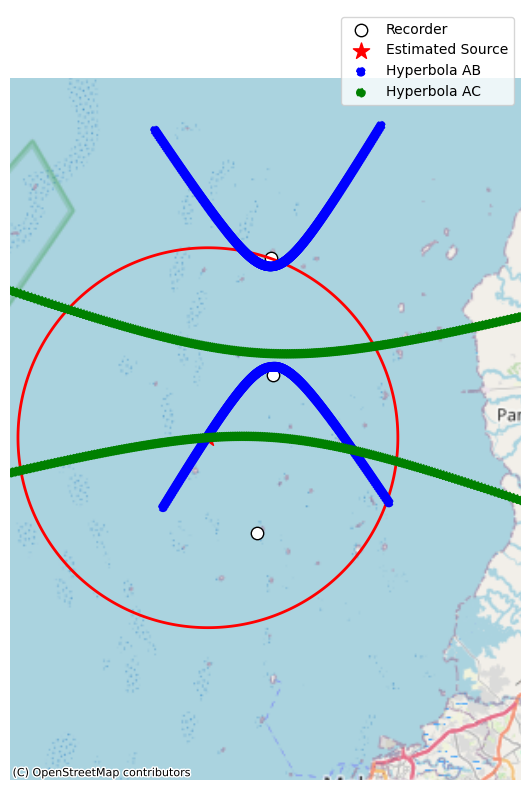

In [67]:
# CELL 2: Standalone map with hyperbolae in Web Mercator coordinates
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from math import sqrt
from shapely.geometry import Point

# Assumes CELL1 has produced rec_map (GeoDataFrame, EPSG:3857)
# and src_map (GeoDataFrame, EPSG:3857).
# If not, recreate recorder GeoDataFrame in EPSG:3857 here:
rec_map = gpd.GeoDataFrame(
    {'label':['A','B','C']},
    geometry=[Point(lon, lat) for lat, lon in a_coords_geo], crs='EPSG:4326'
).to_crs(epsg=3857)
src_map = gpd.GeoDataFrame(
    {'label':['Source']},
    geometry=[Point(lon_est, lat_est)], crs='EPSG:4326'
).to_crs(epsg=3857)

# Extract mercator coordinates for hyperbola foci
rec_coords_merc = list(zip(rec_map.geometry.x, rec_map.geometry.y))
# Compute detection time differences (m)
delta21 = c * (times[1].timestamp() - times[0].timestamp())
delta31 = c * (times[2].timestamp() - times[0].timestamp())

# Hyperbola generator in Mercator meters
def gen_hyp_merc(f1: tuple, f2: tuple, delta: float, num: int = 300):
    x1, y1 = f1
    x2, y2 = f2
    c_f = np.hypot(x2 - x1, y2 - y1) / 2
    a = abs(delta) / 2
    b = sqrt(max(c_f**2 - a**2, 0))
    xc, yc = (x1 + x2) / 2, (y1 + y2) / 2
    theta = np.arctan2(y2 - y1, x2 - x1)
    u = np.linspace(-2, 2, num)
    pts_branches = []
    for sign in (1, -1):
        xp = sign * a * np.cosh(u)
        yp = b * np.sinh(u)
        xr = xc + xp * np.cos(theta) - yp * np.sin(theta)
        yr = yc + xp * np.sin(theta) + yp * np.cos(theta)
        pts_branches.append(np.vstack((xr, yr)).T)
    return pts_branches

# Generate hyperbolae for AB and AC
branches_ab = gen_hyp_merc(rec_coords_merc[0], rec_coords_merc[1], delta21)
branches_ac = gen_hyp_merc(rec_coords_merc[0], rec_coords_merc[2], delta31)

# Plot standalone
fig, ax = plt.subplots(figsize=(8, 8))
# Plot recorders and source
rec_map.plot(ax=ax, color='white', edgecolor='black', markersize=80, label='Recorder')
src_map.plot(ax=ax, color='red', marker='*', markersize=150, label='Estimated Source')
# Hearing radius circle
earth_circle = Point(src_map.geometry.x.iloc[0], src_map.geometry.y.iloc[0]).buffer(radius_km*1000, resolution=100)
circle_gdf = gpd.GeoSeries([earth_circle], crs='EPSG:3857')
circle_gdf.plot(ax=ax, edgecolor='red', linewidth=2, facecolor='none', label=f'Radius = {radius_km:.2f} km')
# Plot hyperbolae branches with labels
for branch in branches_ab:
    hyp_line = gpd.GeoSeries([Point(x, y) for x, y in branch], crs='EPSG:3857')
    hyp_line.plot(ax=ax, linestyle='--', color='blue', linewidth=1, label='Hyperbola AB')
for branch in branches_ac:
    hyp_line = gpd.GeoSeries([Point(x, y) for x, y in branch], crs='EPSG:3857')
    hyp_line.plot(ax=ax, linestyle='-.', color='green', linewidth=1, label='Hyperbola AC')
# Basemap
try:
    provider = ctx.providers.Stamen.Terrain
except (AttributeError, KeyError):
    provider = ctx.providers.OpenStreetMap.Mapnik
ctx.add_basemap(ax, source=provider, crs='EPSG:3857')
# Zoom to recorders extents with dynamic buffer (50% of max dimension)
xmin, ymin, xmax, ymax = rec_map.total_bounds
width = xmax - xmin
height = ymax - ymin
buf = max(width, height) * 0.9  # margin
ax.set_xlim(xmin - buf, xmax + buf)
ax.set_ylim(ymin - buf, ymax + buf)
# Add legend
handles, labels = ax.get_legend_handles_labels()
# Remove duplicate labels
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper right')
# Remove axes and final formatting
ax.set_axis_off()
plt.tight_layout()
plt.show()



## Old plots

In [27]:
import logging
from pathlib import Path
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# logging
logging.basicConfig(level=logging.INFO)

# where your CSVs live
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")
INPUT_DIR = Path(os.path.join(BASE_DIR, "bomb_fishing/data"))

# figure size for daily plots
FIGSIZE = (12, 4)


In [28]:
def load_and_process(csv_file: Path) -> pd.DataFrame:
    """Load CSV and return DataFrame of 'y' bomb events with full timestamps."""
    df = pd.read_csv(csv_file)
    df = df[df["Bomb"] == "y"].copy()
    if df.empty:
        return pd.DataFrame(columns=["file_id", "when"])
    # parse base datetime from filename (e.g. 20240623_200400)
    df["base_dt"] = (
        df["File"]
        .str.extract(r"(\d{8}_\d{6})")[0]
        .apply(lambda s: datetime.strptime(s, "%Y%m%d_%H%M%S"))
    )
    # add the HH:MM:SS offset
    df["offset"] = pd.to_timedelta(df["Timestamp (HH:MM:SS)"])
    df["when"] = df["base_dt"] + df["offset"]
    df["file_id"] = csv_file.stem
    return df[["file_id", "when"]]

def plot_daily_timelines(events: pd.DataFrame) -> None:
    """For each calendar day, draw a separate 24h timeline."""
    events["date"] = events["when"].dt.date
    colours = plt.cm.tab20.colors

    for day, grp in events.groupby("date"):
        fig, ax = plt.subplots(figsize=FIGSIZE)
        files = sorted(grp["file_id"].unique())
        colour_map = {f: colours[i % len(colours)] for i, f in enumerate(files)}

        for fid, sub in grp.groupby("file_id"):
            y = files.index(fid)
            ax.scatter(sub["when"], [y] * len(sub),
                       color=colour_map[fid], s=40, label=fid)
            for _, row in sub.iterrows():
                ts = row["when"].strftime("%H:%M:%S")
                ax.text(row["when"], y, ts,
                        fontsize=6, ha="center",
                        va="bottom", rotation=45)

        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax.set_yticks(range(len(files)))
        ax.set_yticklabels(files)
        ax.set_xlabel("Time of day")
        ax.set_ylabel("File")
        ax.set_title(f"Bomb detections on {day:%Y-%m-%d}")
        ax.legend(title="File", bbox_to_anchor=(1.05, 1),
                  loc="upper left", fontsize=6)
        fig.tight_layout()
        plt.show()


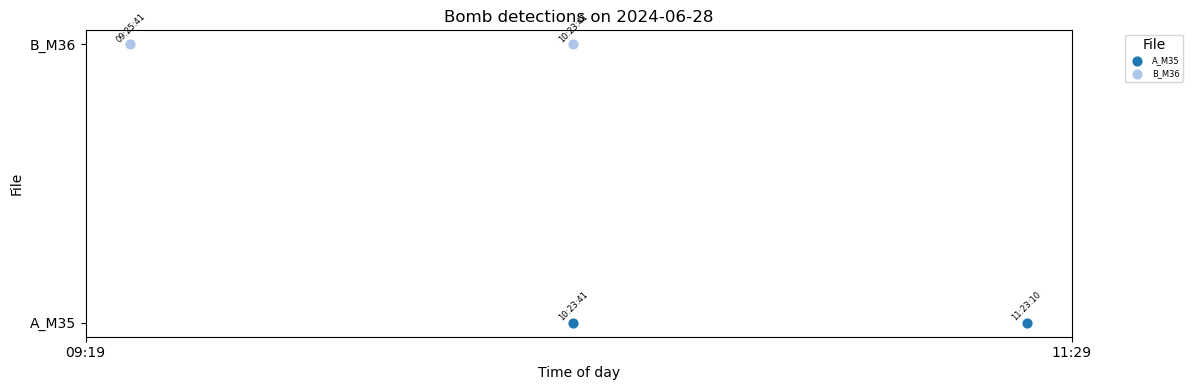

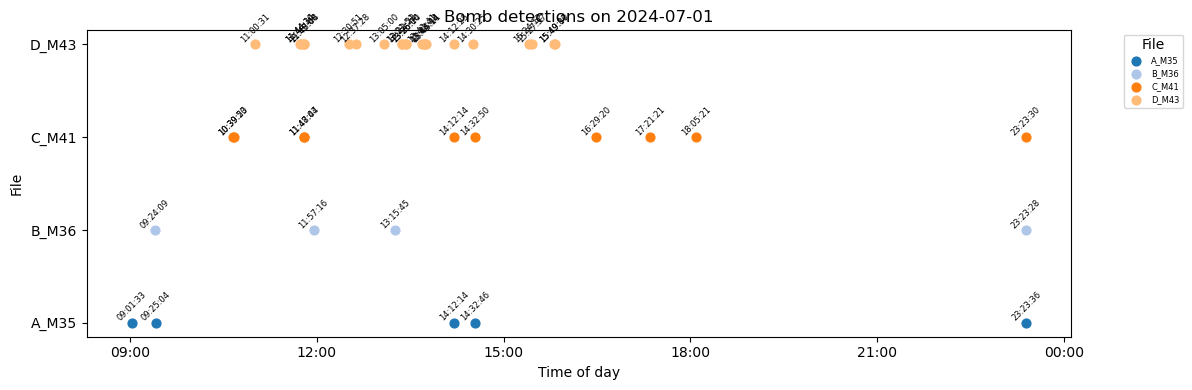

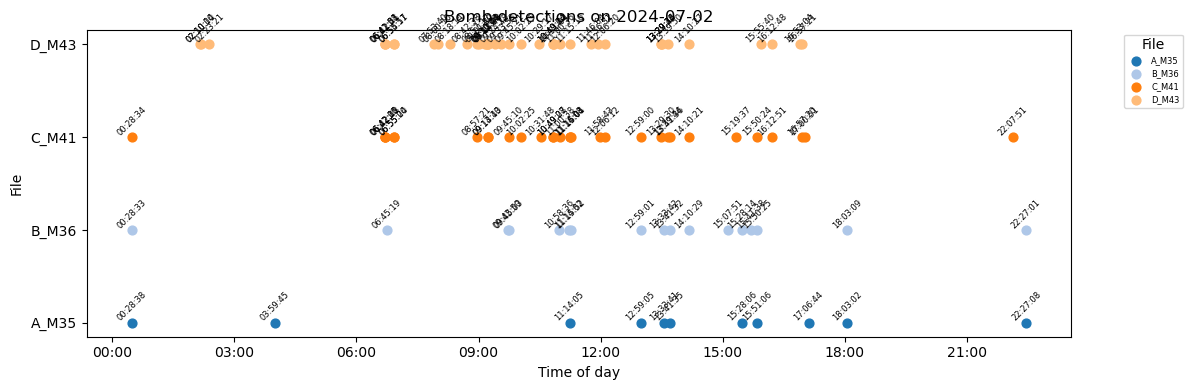

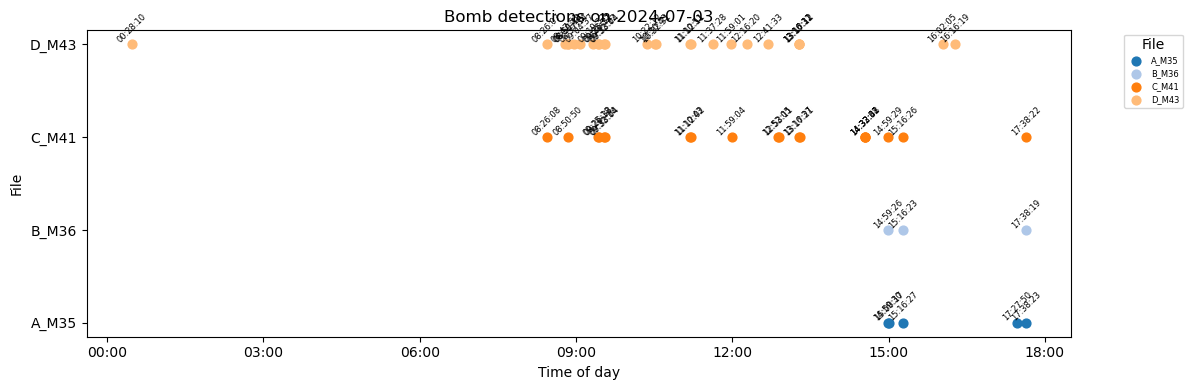

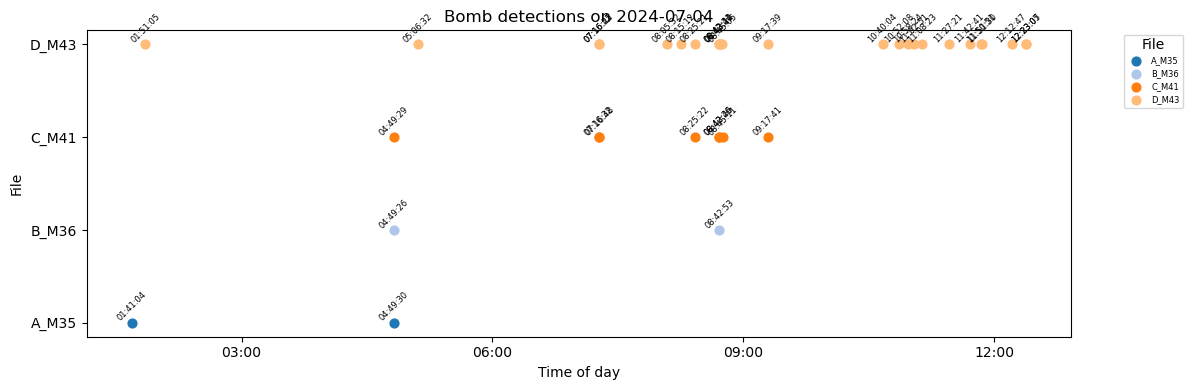

In [29]:
# collect all 'y' events
csvs = list(INPUT_DIR.glob("*.csv"))
all_events = pd.concat(
    [load_and_process(f) for f in csvs],
    ignore_index=True
)

# plot or warn
if all_events.empty:
    logging.warning("No 'y' entries found in any CSV.")
else:
    plot_daily_timelines(all_events)
